In [27]:
import numpy as np
import matplotlib.pyplot as plt
from torchAA import torchAA
from torchNMF import NMF
from ShiftNMF_half_frequencies import ShiftNMF
from torchShiftAA import torchShiftAA
from tqdm.notebook import tqdm
import torch

from scipy.special import softmax

## Data

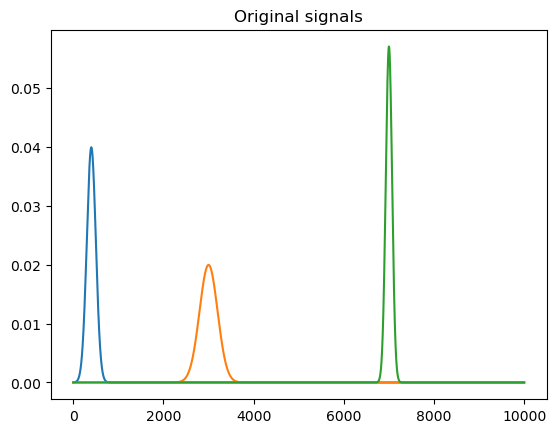

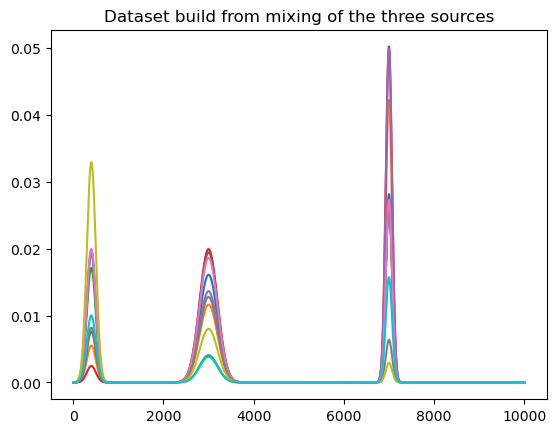

In [28]:
#Create data
# Define random sources, mixings and shifts; H, W and tau
N, M, d = 10, 10000, 3
Fs = 1000  # The sampling frequency we use for the simulation
t0 = 10    # The half-time interval we look at
t = np.arange(-t0, t0, 1/Fs)  # the time samples
f = np.arange(-Fs/2, Fs/2, Fs/len(t))  # the corresponding frequency samples

def gauss(mu, s, time):
    return 1/(s*np.sqrt(2*np.pi))*np.exp(-1/2*((time-mu)/s)**2)


def shift_dataset(W, H, tau):
    # Get half the frequencies
    Nf = H.shape[1] // 2 + 1
    # Fourier transform of S along the second dimension
    Hf = np.fft.fft(H, axis=1)
    # Keep only the first Nf[1] elements of the Fourier transform of S
    Hf = Hf[:, :Nf]
    # Construct the shifted Fourier transform of S
    Hf_reverse = np.fliplr(Hf[:, 1:Nf - 1])
    # Concatenate the original columns with the reversed columns along the second dimension
    Hft = np.concatenate((Hf, np.conj(Hf_reverse)), axis=1)
    f = np.arange(0, M) / M
    omega = np.exp(-1j * 2 * np.pi * np.einsum('Nd,M->NdM', tau, f))
    Wf = np.einsum('Nd,NdM->NdM', W, omega)
    # Broadcast Wf and H together
    Vf = np.einsum('NdM,dM->NM', Wf, Hft)
    V = np.fft.ifft(Vf)
    return V

# Random mixings:
W = np.random.rand(N, d)
# Random gaussian shifts
tau = np.zeros(shape=(N, d))
#tau = np.random.randint(0, 1000, size=(N, d))
# Purely positive underlying signals. I define them as 3 gaussian peaks with random mean and std.
mean = [40, 300, 700]
std = [10, 20, 7]
t = np.arange(0, 1000, 0.1)
H = np.array([gauss(m, s, t) for m, s in list(zip(mean, std))])
plt.figure()
for signal in H:
    plt.plot(signal)
plt.title("Original signals")
plt.show()

X = shift_dataset(W, H, tau)


plt.figure()
for signal in X:
    plt.plot(signal.real)
plt.title("Dataset build from mixing of the three sources")
plt.show()

## Regular NMF

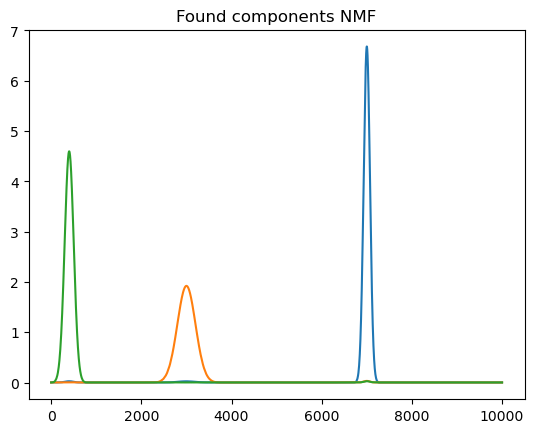

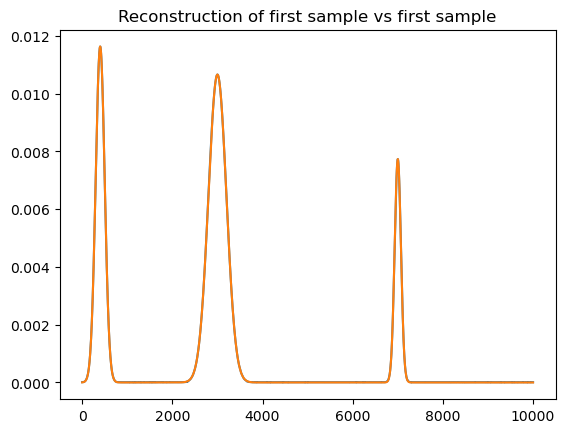

In [4]:

nmf = NMF(X, 3)
W, H = nmf.fit(verbose=True)
recon = np.matmul(W, H)

for signal in H:
    plt.plot(signal)
plt.title("Found components NMF")
plt.show()

plt.plot(recon[1])
plt.plot(X[1])
plt.title("Reconstruction of first sample vs first sample")
plt.show()

## Shift NMF

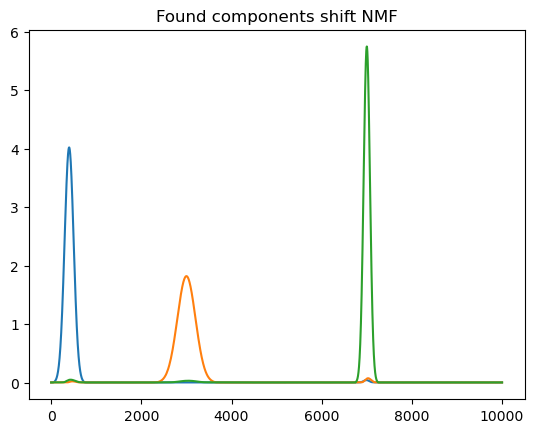

c:\Users\Lenovo\miniconda3\envs\fp\Lib\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


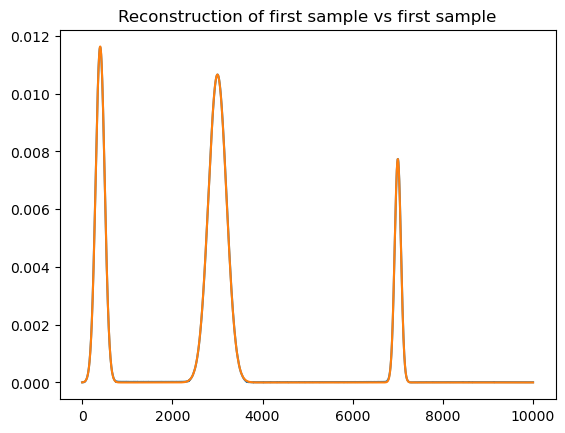

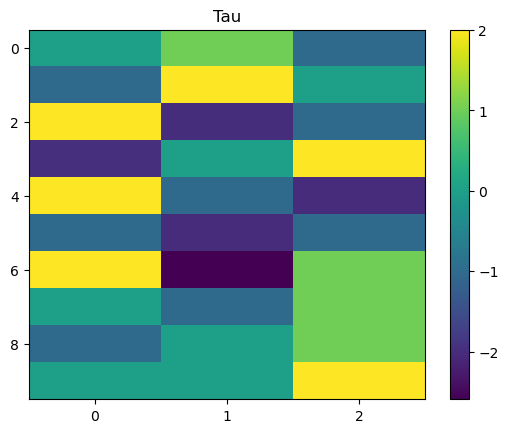

In [3]:

nmf = ShiftNMF(X, 3)
W, H, tau = nmf.fit(verbose=True)
recon = nmf.recon.detach().numpy()

for signal in H:
    plt.plot(signal)
plt.title("Found components shift NMF")
plt.show()

plt.plot(recon[1])
plt.plot(X[1])
plt.title("Reconstruction of first sample vs first sample")
plt.show()

plt.figure()
plt.imshow(tau, aspect='auto', interpolation="none")
ax = plt.gca()
ax.set_xticks(np.arange(0, 3, 1))
plt.colorbar()
plt.title("Tau")
plt.show()
print(tau)

## Regular AA

  0%|          | 0/1 [00:00<?, ?it/s]

c:\Users\Lenovo\OneDrive\Skrivebord\Fagprojekt\02466Fagprojekt2023\torchAA.py:15: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\Copy.cpp:276.)
  self.X = torch.tensor(X, dtype=torch.double)
c:\Users\Lenovo\OneDrive\Skrivebord\Fagprojekt\02466Fagprojekt2023\torchAA.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.C = torch.tensor(self.C, requires_grad=True, dtype=torch.double)


c:\Users\Lenovo\miniconda3\envs\fp\Lib\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


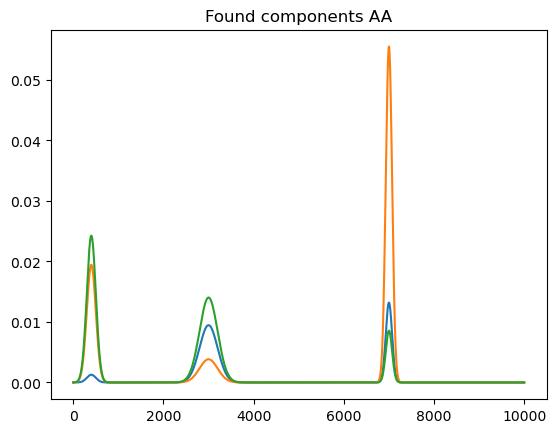

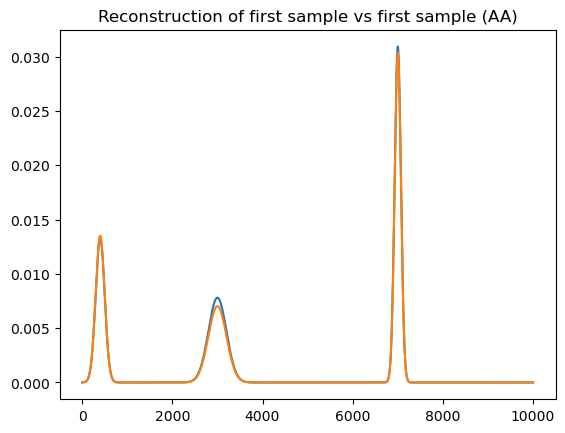

In [3]:
best_loss = np.inf
for _ in tqdm(range(1)):
    AA = torchAA(X, 3)
    C, S, loss = AA.fit(verbose=True, return_loss=True)
    if loss[-1] < best_loss:
        CX = np.matmul(C, X)
        recon = np.matmul(S, CX)
        best_loss = loss[-1]

for signal in CX:
    plt.plot(signal)
plt.title("Found components AA")
plt.show()

plt.plot(recon[1])
plt.plot(X[1])
plt.title("Reconstruction of first sample vs first sample (AA)")
plt.show()

## Shift AA

epoch: 1, Loss: 0.2678703388303233
epoch: 2, Loss: 0.23586053508068833
epoch: 3, Loss: 0.1860226738044223
epoch: 4, Loss: 0.14108993015976093
epoch: 5, Loss: 0.11463246100550478
epoch: 6, Loss: 0.09988319035174517
epoch: 7, Loss: 0.09248409772537025
epoch: 8, Loss: 0.09185652265730886
epoch: 9, Loss: 0.09130351313021834
epoch: 10, Loss: 0.08638478110118479
epoch: 11, Loss: 0.08040164859609465
epoch: 12, Loss: 0.07943297958933335
epoch: 13, Loss: 0.08110530734737026
epoch: 14, Loss: 0.080380108588076
epoch: 15, Loss: 0.07724683226254629
epoch: 16, Loss: 0.07419963983242277
epoch: 17, Loss: 0.07332275695335067
epoch: 18, Loss: 0.0721893891641398
epoch: 19, Loss: 0.07193675181392166
epoch: 20, Loss: 0.07212224141425533
epoch: 21, Loss: 0.07178387942278099
epoch: 22, Loss: 0.07096541966734594
epoch: 23, Loss: 0.07009874320313914
epoch: 24, Loss: 0.06964184726387596
epoch: 25, Loss: 0.06965331397009496


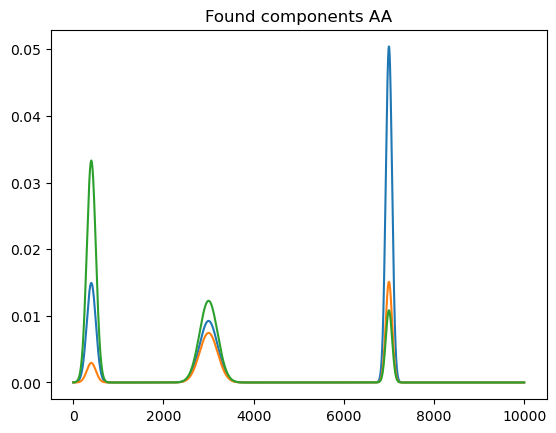

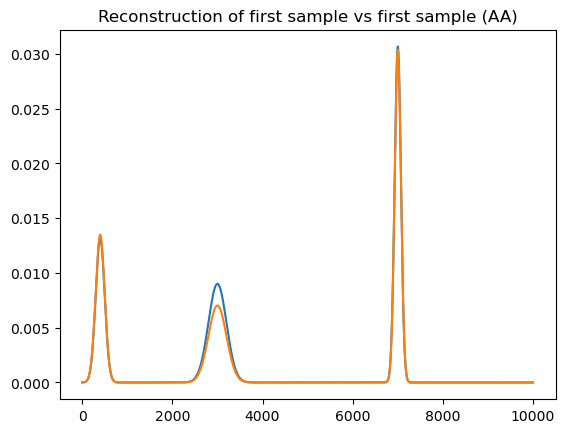

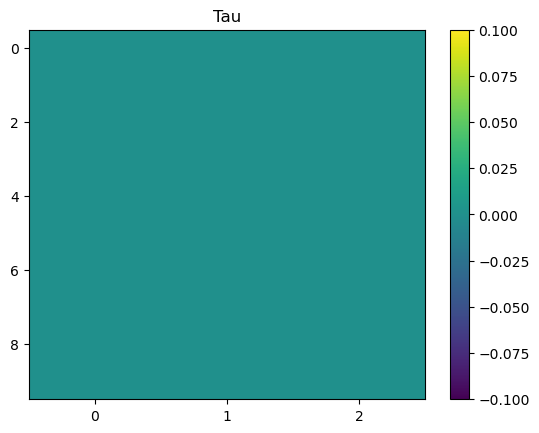

In [4]:
AA = torchShiftAA(X, 3)
C, S, tau = AA.fit(verbose=True)

recon = AA.recon.detach().resolve_conj().numpy()
A = torch.fft.ifft(AA.A_F).detach().numpy()

CX = A
SCX = recon

for signal in CX:
    plt.plot(signal)
plt.title("Found components AA")
plt.show()

plt.plot(recon[1])
plt.plot(X[1])
plt.title("Reconstruction of first sample vs first sample (AA)")
plt.show()

plt.figure()
plt.imshow(tau, aspect='auto', interpolation="none")
ax = plt.gca()
ax.set_xticks(np.arange(0, 3, 1))
plt.colorbar()
plt.title("Tau")
plt.show()